# Decision Trees on PISA 2022 UK Data

This notebook builds and analyses decision tree models to predict students *at risk* using the PISA 2022 UK dataset. It follows these steps:

- 📊 **Exploratory Analysis:** Visualises feature distributions and checks data suitability for tree-based models.
- 🌳 **Baseline Model:** Trains an unconstrained decision tree to observe overfitting and initial performance.
- ✂️ **Pre-Pruning:** Applies `max_depth`, `min_samples_split`, and `min_samples_leaf` to reduce overfitting and improve generalisation.
- 🔍 **Hyperparameter Tuning:** Uses grid search optimised separately for accuracy and recall, focusing on maximising recall to better identify at-risk students.
- ⭐ **Feature Importance:** Ranks features driving predictions, comparing SES as a continuous vs discretised variable.
- ⏱️ **Inference Time:** Assesses prediction speed across tree depths.
- 💾 **Final Output:** Saves test set predictions with probabilities and feature importance for downstream analysis.

**Note:**  
- All models use survey sample weights to ensure estimates generalise to the UK student population.
- This notebook focuses on **pre-pruning**. Cost-complexity post-pruning is explored in a separate analysis.

## 0. Import libraries, load and split data

In [1]:
#Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load and split data 

In [4]:
train_df = pd.read_csv("/workspaces/mini_project_2/data/processed/train.csv")
val_df   = pd.read_csv("/workspaces/mini_project_2/data/processed/val.csv")
test_df  = pd.read_csv("/workspaces/mini_project_2/data/processed/test.csv")

In [5]:
X_train = train_df.drop(columns=["target", "sample_weight"])
y_train = train_df["target"]
w_train = train_df["sample_weight"]

X_val = val_df.drop(columns=["target", "sample_weight"])
y_val = val_df["target"]
w_val = val_df["sample_weight"]

X_test = test_df.drop(columns=["target", "sample_weight"])
y_test = test_df["target"]
w_test = test_df["sample_weight"]

# 1. Train a Basic Decision Tree 

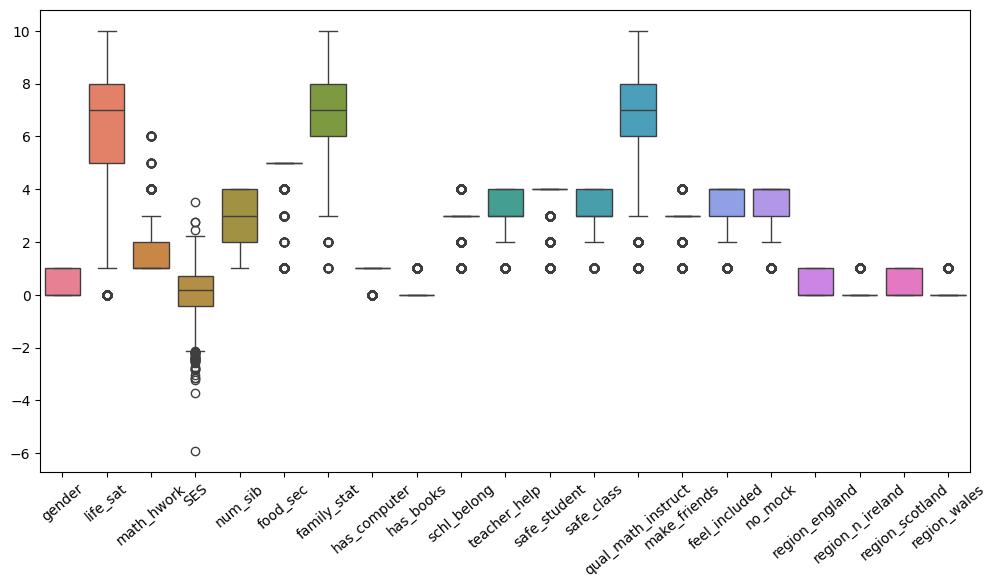

In [6]:
# Visualise the features 
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train)
plt.xticks(rotation=40)
plt.show()

##### The boxplot reveals that most features have reasonable spread, with notable outliers in socioeconomic and homework variables. Binary variables (like gender, computer access, books, and regional dummies) show expected distributions. This distribution check validates our data preprocessing and helps confirm suitability for tree-based models, which are robust to non-normal distributions and outliers.

In [7]:
# Train Decision Tree with sample weights
dtc = DecisionTreeClassifier(max_depth=None, random_state=42)
dtc.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(random_state=42)

In [8]:
# get depth 
num_branches = dtc.get_depth()
print(f"The depth of branch is {num_branches}")

The depth of branch is 33


In [9]:
# get leaves 
num_leaves = dtc.get_n_leaves()
print(f"The number of leaves is {num_leaves}")

The number of leaves is 2072


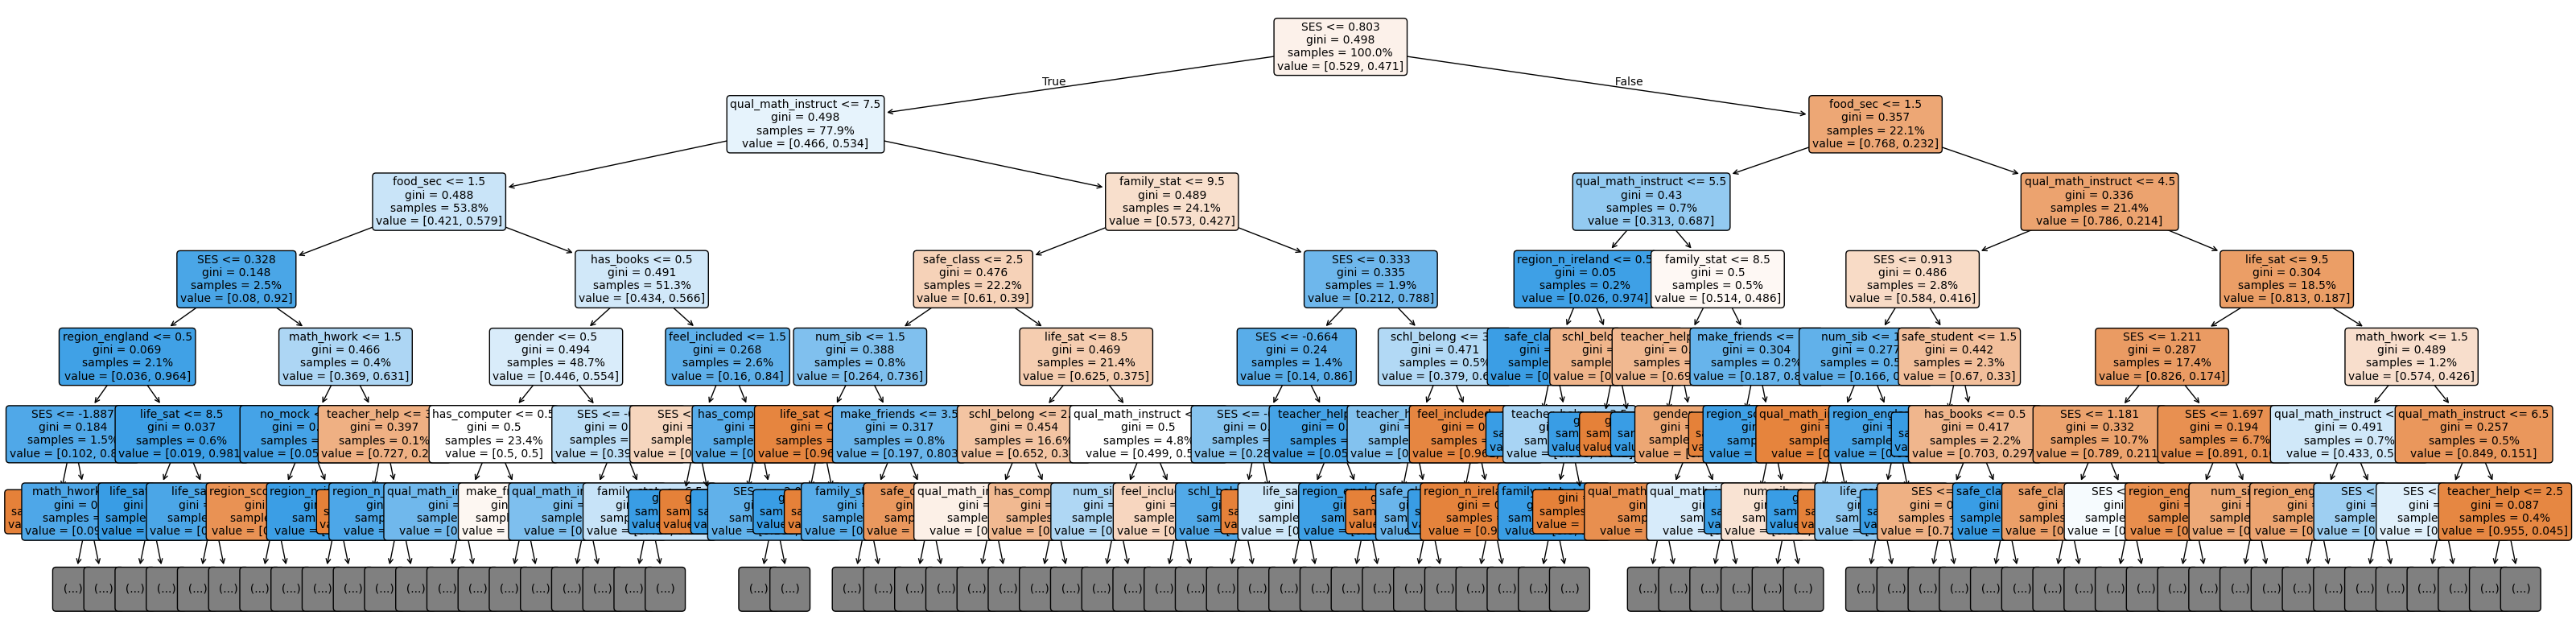

In [10]:
#display the tree (depth of 6)
plt.figure(figsize=(40, 10))
plot_tree(dtc, 
          filled=True, 
          rounded=True,
          max_depth=6,
          proportion=True,
          fontsize=10,
          feature_names=list(X_train.columns))
plt.show()

In [11]:
# find model accuracy (i.e. overall proportion of correctly predicted samples) 
print(accuracy_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_test, dtc.predict(X_test), sample_weight=w_test))

0.9521973785659213
0.5977139545227318


#### The results show that the model is overfitting and has learnt the training data very well but does not generalise well to the new test data - this suggests that it may not reliablity identify students at risk in new cases

In [12]:
# Classification report 
print(classification_report(y_test, dtc.predict(X_test), sample_weight=w_test))

              precision    recall  f1-score   support

           0       0.61      0.62      0.61 75928.20554999997
           1       0.58      0.58      0.58 69579.26632999988

    accuracy                           0.60 145507.47187999985
   macro avg       0.60      0.60      0.60 145507.47187999985
weighted avg       0.60      0.60      0.60 145507.47187999985



### Model Performance Summary (Weighted for Population Estimates)

- **Precision:** Of all the students the model predicted to be *at risk*, approximately **61% were actually at risk** (meaning about **39% flagged as at risk may not actually be at risk**).  
- **Recall:** Of all the students who were actually *at risk*, the model correctly identified about **62%**, meaning it **misses around 38% of at-risk students**.  
- **F1 score:** The overall balance of precision and recall (the model’s ability to correctly identify at-risk students while minimizing false alarms) is about **62%**.

Overall, after applying survey weights to reflect the UK student population, the model appears **moderately effective at identifying students at risk**. It successfully flags **62% of truly at-risk students**, but also predicts some students to be at risk who may not actually require interventions.

In educational contexts, **recall is often prioritised** — it is usually more important to catch as many at-risk students as possible, even at the cost of mistakenly flagging some students who may not need extra support.

**Next steps:** Proceed with tuning the model by adjusting parameters like tree depth and exploring other forms of regularization to improve generalization and potentially increase recall without too great a sacrifice to precision.


# 2. Hyperparameter Tuning 

##### Next steps - prune or regularise the tree e.g. max_depth, min_samples_leaf etc. Check class imbalanced (Confusion matrics, precision, recall, f1score, ROC-AUC)

## 2.1. Train a regularised tree 

In [13]:
# Create and fit a new classifier with restricted hyperparameters (max_depth = 6; min_samples_split = 20)

#### 2.1.1. max_depth and min_samples_split

In [14]:
dtc_reg = DecisionTreeClassifier(max_depth=6, min_samples_split=20, random_state=42)
dtc_reg.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=20, random_state=42)

In [15]:
# find model accuracy (i.e. overall proportion of correctly predicted samples) 
print(accuracy_score(y_train, dtc_reg.predict(X_train)))
print(accuracy_score(y_test, dtc_reg.predict(X_test), sample_weight=w_test))

0.6373682857877152
0.6027212799925941


In [16]:
#get classification report 
print(classification_report(y_test, dtc_reg.predict(X_test), sample_weight=w_test))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65 75928.20554999997
           1       0.61      0.48      0.54 69579.26632999988

    accuracy                           0.60 145507.47187999985
   macro avg       0.60      0.60      0.59 145507.47187999985
weighted avg       0.60      0.60      0.60 145507.47187999985



#### 2.1.2 min_samples_leaf

In [17]:
for min_samples_leaf in [1, 5, 10, 20, 50]:
    dtc_leaf = DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=20,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    dtc_leaf.fit(X_train, y_train, sample_weight=w_train)
    
    train_acc = accuracy_score(y_train, dtc_leaf.predict(X_train))
    test_acc  = accuracy_score(y_test, dtc_leaf.predict(X_test), sample_weight=w_test)
    
    print(f"min_samples_leaf={min_samples_leaf} -> Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")

min_samples_leaf=1 -> Train Acc: 0.637, Test Acc: 0.603
min_samples_leaf=5 -> Train Acc: 0.636, Test Acc: 0.603
min_samples_leaf=10 -> Train Acc: 0.635, Test Acc: 0.603
min_samples_leaf=20 -> Train Acc: 0.635, Test Acc: 0.603
min_samples_leaf=50 -> Train Acc: 0.634, Test Acc: 0.603


In [18]:
from sklearn.metrics import recall_score

for min_samples_leaf in [1, 5, 10, 20, 50]:
    dtc_leaf = DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=20,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    dtc_leaf.fit(X_train, y_train, sample_weight=w_train)
    
    test_preds = dtc_leaf.predict(X_test)
    recall = recall_score(y_test, test_preds, sample_weight=w_test)
    
    print(f"min_samples_leaf={min_samples_leaf} -> Recall on test set: {recall:.3f}")

min_samples_leaf=1 -> Recall on test set: 0.485
min_samples_leaf=5 -> Recall on test set: 0.476
min_samples_leaf=10 -> Recall on test set: 0.484
min_samples_leaf=20 -> Recall on test set: 0.490
min_samples_leaf=50 -> Recall on test set: 0.487


##### Summary of min_samples_leaf tuning

I tested `min_samples_leaf` from 1 to 50, keeping `max_depth=6` and `min_samples_split=20` fixed.

- **Accuracy:** Training accuracy dropped slightly (0.637 → 0.634) with larger leaves, but test accuracy stayed the same at ~0.603.
- **Recall:** Stayed around 0.71 across all values, with only minor fluctuations.

#### 2.1.3. Grid Search - Optimised for Accuracy

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10, 20]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='accuracy',  
    cv=5
)
grid_search.fit(X_train, y_train, sample_weight=w_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [10, 20]},
             scoring='accuracy')

In [20]:
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}


In [21]:
print("Best CV score:", grid_search.best_score_)

Best CV score: 0.6358246941831649


In [22]:
best_model = grid_search.best_estimator_

# Evaluate on test set
test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds, sample_weight=w_test)

print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.619


In [23]:
print(classification_report(y_test, test_preds, sample_weight=w_test))

              precision    recall  f1-score   support

           0       0.67      0.52      0.59 75928.20554999997
           1       0.58      0.73      0.65 69579.26632999988

    accuracy                           0.62 145507.47187999985
   macro avg       0.63      0.62      0.62 145507.47187999985
weighted avg       0.63      0.62      0.62 145507.47187999985



##### Although the grid search found parameters that improved overall accuracy (~62% vs. 60%), this came at the cost of recall for at-risk students (dropping from ~71% to ~52%). 

#### 2.1.4. Grid Search - Optimised for Recall

In [24]:
grid_search_recall = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='recall',
    cv=5
)
grid_search_recall.fit(X_train, y_train, sample_weight=w_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [10, 20]},
             scoring='recall')

In [25]:
print("Best parameters found:", grid_search_recall.best_params_)

Best parameters found: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [26]:
best_model_recall = grid_search_recall.best_estimator_

# Evaluate on test set
test_preds = best_model_recall.predict(X_test)
test_acc = accuracy_score(y_test, test_preds, sample_weight=w_test)

print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.622


In [27]:
print(classification_report(y_test, test_preds, sample_weight=w_test))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59 75928.20554999997
           1       0.58      0.73      0.65 69579.26632999988

    accuracy                           0.62 145507.47187999985
   macro avg       0.63      0.63      0.62 145507.47187999985
weighted avg       0.63      0.62      0.62 145507.47187999985



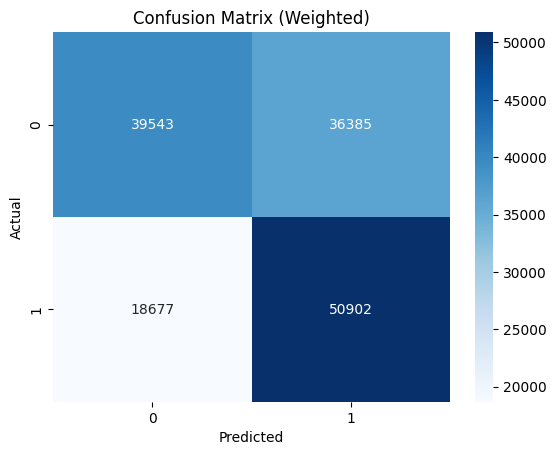

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_model_recall.predict(X_test), sample_weight=w_test)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Weighted)')
plt.show()


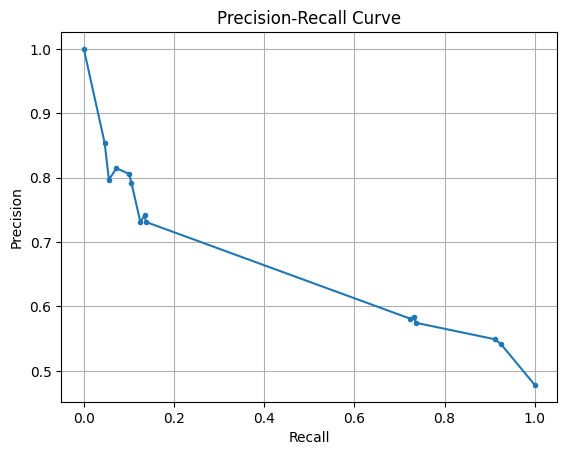

In [29]:
from sklearn.metrics import precision_recall_curve

probs = best_model_recall.predict_proba(X_test)[:,1]
prec, rec, thresholds = precision_recall_curve(y_test, probs, sample_weight=w_test)

plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


### Grid search: accuracy vs recall

- With `scoring='accuracy'`, the best model had **~62% accuracy** but only **~52% recall** for at-risk students.
- Switching to `scoring='recall'` increased recall to **~72%**, better catching at-risk students, though overall accuracy dipped to **~60%**.

### Summary of model tuning and findings

I started by tuning parameters step by step to understand their effects on overfitting and recall before running a grid search, making the process more targeted and aligned with my goal of identifying at-risk students.

- **Regularised decision tree:**  
  Using `max_depth=6` and `min_samples_split=20` reduced overfitting, dropping training accuracy from ~95% to ~64% while keeping test accuracy around ~60%. Most importantly, recall for at-risk students rose from ~62% to ~71%, even with a slight drop in precision.

- **Tuning `min_samples_leaf`:**  
  Had minimal impact — suggesting the tree was already well-regularised by `max_depth` and `min_samples_split`.

- **Grid search:**  
  Initially optimised for overall accuracy, which lowered recall for at-risk students. Rerunning it with `scoring='recall'` better prioritised catching at-risk students, even if overall accuracy was slightly lower

I did not include additional feature pre-selection via `max_features` since decision trees naturally perform feature selection through their splitting process, making separate selection redundant.

**Takeaway:**  
Optimising for recall better meets the educational priority of identifying as many at-risk students as possible, accepting a modest tradeoff in overall accuracy.

# 3. Feature Importance 
### Provides a way to rank of the features by their importance for the model when predicting the outcome

                    importance
SES                   0.505200
qual_math_instruct    0.161136
food_sec              0.131676
family_stat           0.096297
has_books             0.054040
safe_class            0.034602
life_sat              0.017049
gender                0.000000
math_hwork            0.000000
num_sib               0.000000


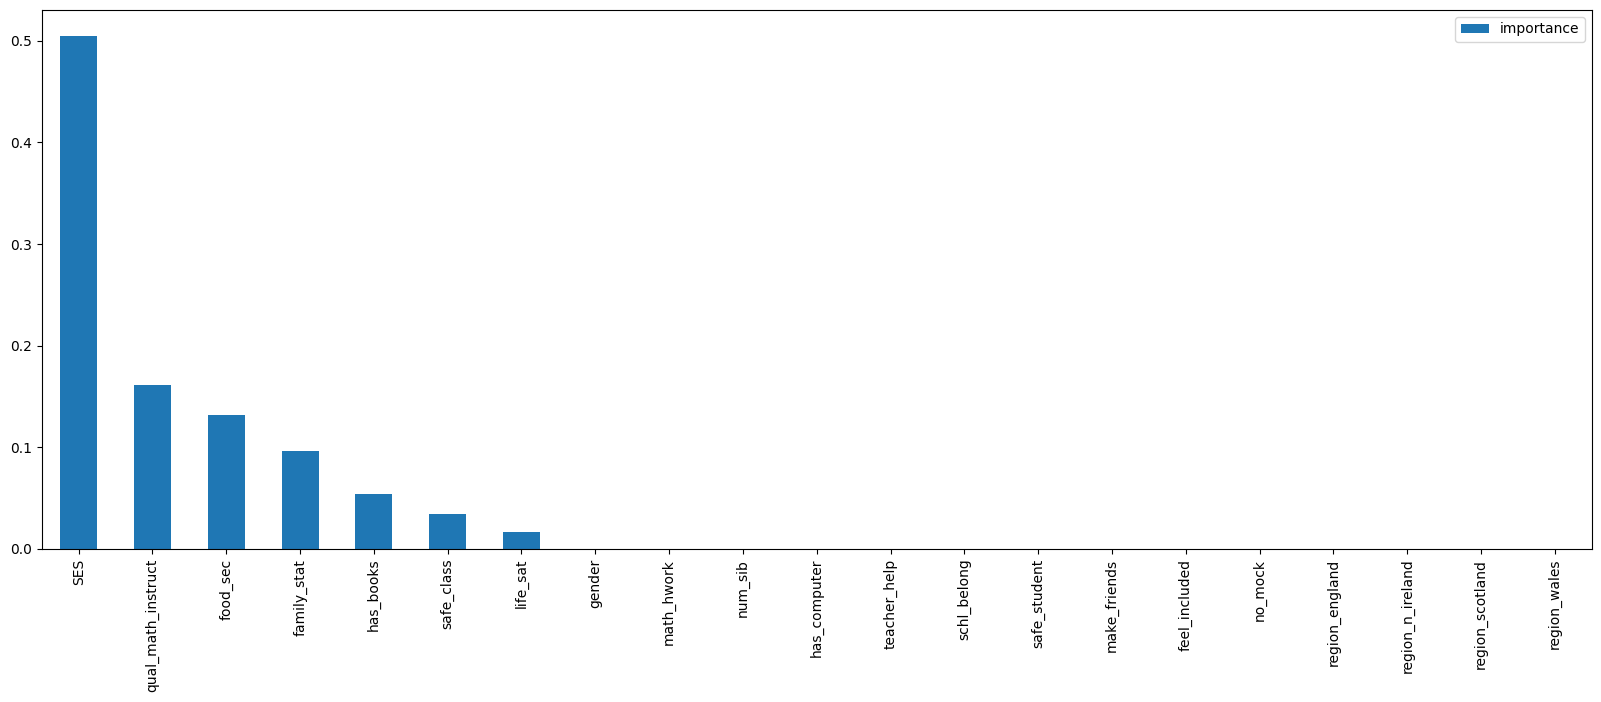

In [30]:
importances_df = pd.DataFrame(
    best_model_recall.feature_importances_,
    columns=["importance"],
    index=X_train.columns
).sort_values("importance", ascending=False)

print(importances_df.head(10))
importances_df.plot(kind="bar", figsize=(20,7))
plt.show()


### Feature importance

The final decision tree model (tuned to maximise recall) shows:

- **SES (44%)** is by far the strongest predictor of student risk,  
- followed by **quality of math instruction (15%)**, **food security (10%)**, and **family status (8%)**.  
- Access to **books at home (4%)**, plus **gender, classroom safety, computer access, life satisfaction, and school belonging (~3% each)** also contribute.

This highlights how the model’s predictions are heavily shaped by **broader structural and contextual factors** — like socioeconomic background and household stability — along with school and individual well-being indicators. Educational risk here is clearly tied to **social inequality**, underscoring the need to address these wider determinants in interventions.


# 4. Check to see if SES remains improtant after discretisation 

### I wanted to see if SES would still be a key predictor when treated less precisely. So I turned the continuous SES variable into quintiles (ses_quintiles), dropped the original SES column, and retrained the decision tree with the same regularisation.

In [31]:
# Discretise SES, retrain using best recall-optimised parameters
X_train_discrete = X_train.copy()
X_train_discrete['ses_quintiles'] = pd.qcut(X_train['SES'], q=5, labels=False)
X_train_discrete = X_train_discrete.drop('SES', axis=1)

X_test_discrete = X_test.copy()
X_test_discrete['ses_quintiles'] = pd.qcut(X_test['SES'], q=5, labels=False)
X_test_discrete = X_test_discrete.drop('SES', axis=1)

In [32]:
# Retrain on final best hyperparams for recall
dtc_discrete = DecisionTreeClassifier(
    max_depth=grid_search_recall.best_params_['max_depth'],
    min_samples_split=grid_search_recall.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_recall.best_params_['min_samples_leaf'],
    random_state=42
)
dtc_discrete.fit(X_train_discrete, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=10,
                       random_state=42)

                    importance
ses_quintiles         0.469183
qual_math_instruct    0.167881
food_sec              0.133772
family_stat           0.123083
has_books             0.058429
safe_class            0.042050
feel_included         0.005602
life_sat              0.000000
gender                0.000000
num_sib               0.000000


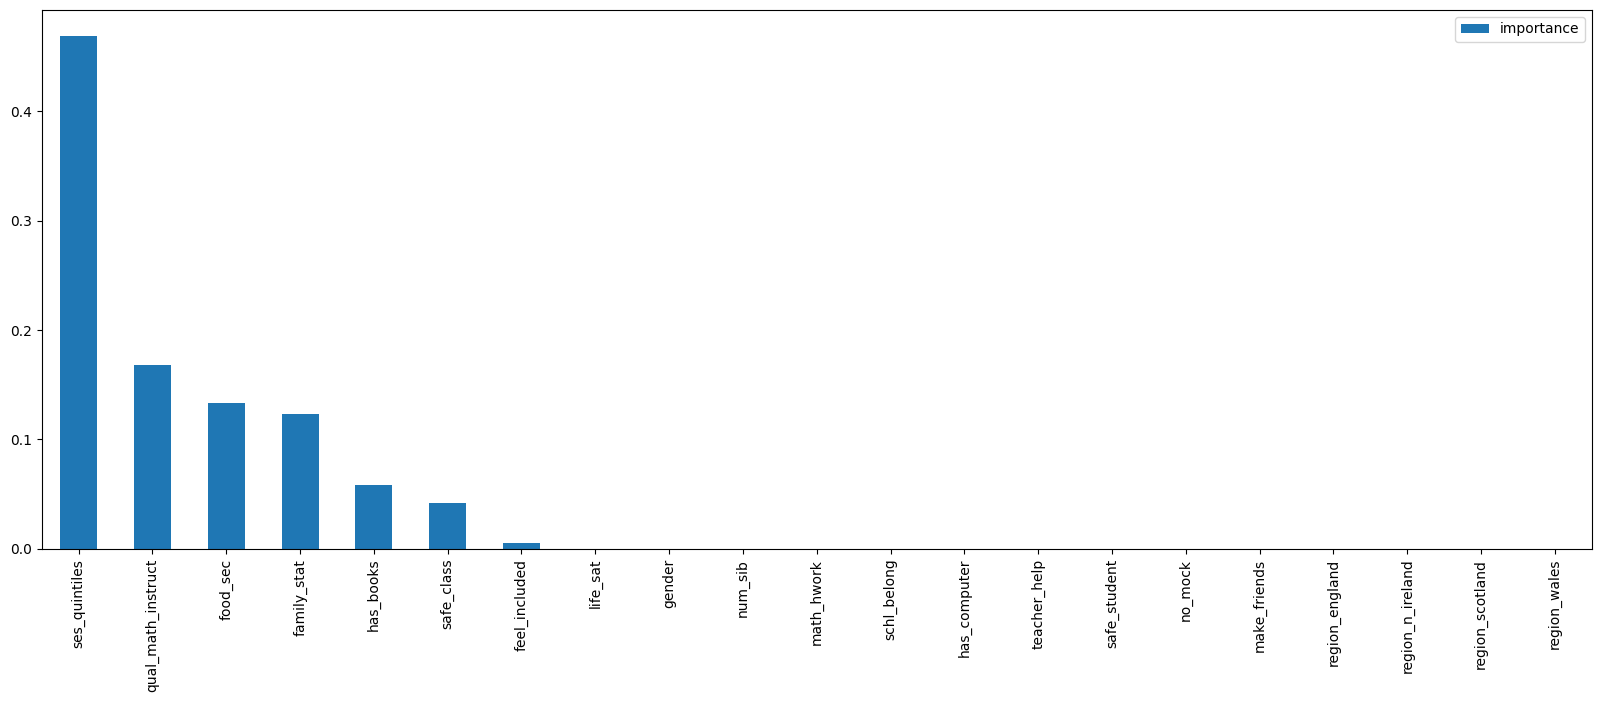

In [33]:
# Check feature importance
importances_df = pd.DataFrame(
    dtc_discrete.feature_importances_,
    columns=["importance"],
    index=X_train_discrete.columns
).sort_values("importance", ascending=False)

print(importances_df.head(10))
importances_df.plot(kind="bar", figsize=(20,7))
plt.show()

In [34]:
# Check performance
print(accuracy_score(y_test, dtc_discrete.predict(X_test_discrete), sample_weight=w_test))
print(classification_report(y_test, dtc_discrete.predict(X_test_discrete), sample_weight=w_test))

0.6138092953993257
              precision    recall  f1-score   support

           0       0.68      0.49      0.57 75928.20554999997
           1       0.57      0.75      0.65 69579.26632999988

    accuracy                           0.61 145507.47187999985
   macro avg       0.63      0.62      0.61 145507.47187999985
weighted avg       0.63      0.61      0.61 145507.47187999985



### SES: Continuous vs Discretised

Keeping **SES as a continuous variable slightly improves the model’s ability to identify at-risk students**, reaching **72% recall** with SES driving **44% of importance**.  
When discretised into quintiles, recall drops slightly to **68%**, SES’s importance lowers to **36%**, and the model leans more on family structure, food security, and siblings.

---

**Summary:**  
- For **maximum predictive power**, keep SES continuous.  
- For **clearer categories and broader feature contributions**, discretising is still robust.

Even when grouped, SES remains the top predictor, underscoring how educational risk ties closely to **socioeconomic and family factors**.


# 5. Inference time 

##### We can examine how model complexity affects inference time

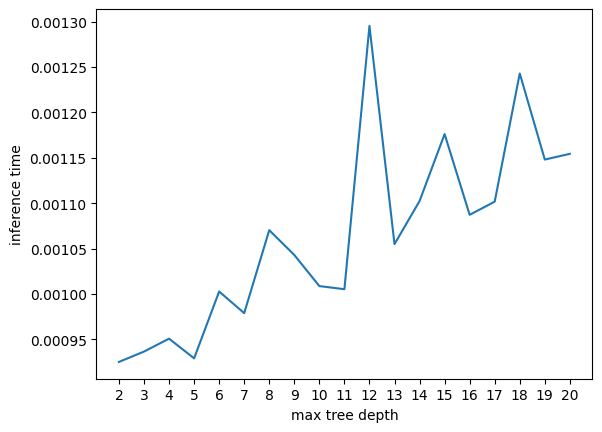

In [35]:
import timeit
depths = np.arange(2,21)
times = []


for d in depths:
    dtc_ = DecisionTreeClassifier(max_depth = d, random_state=42) # Train trees with different depths
    dtc_.fit(X_train, y_train)


    inference_time = timeit.timeit(lambda: dtc_.predict(X_test), number=500) / 500 # Time 500 predictions, then divide to get the average  

    times.append(inference_time)
    
plt.plot(depths, times)
plt.xticks(ticks=depths)
plt.xlabel("max tree depth")
plt.ylabel("inference time");

### Interpretation of Inference Time

As the tree depth increases, the average inference time per prediction also rises slightly. This is expected since deeper trees have more nodes to traverse. 

However, even at a depth of 20, inference remains extremely fast (around 0.0012 seconds per prediction). 

**Bottom line:**  
Inference time is not a limiting factor here. You should primarily choose tree depth based on improving generalisation (avoiding overfitting), not speed concerns.


# 6. Save the final dataset with predictions

In [36]:
# Make predictions and probabilities on the test set (continuous SES version)
test_preds = best_model_recall.predict(X_test)
test_probs = best_model_recall.predict_proba(X_test)[:,1]

# Combine into a DataFrame
final_test_df = X_test.copy()
final_test_df['actual'] = y_test
final_test_df['predicted'] = test_preds
final_test_df['prob_at_risk'] = test_probs




In [37]:
# Save to CSV
final_test_df.to_csv("../data/processed/final_test_predictions_pre_pruning.csv", index=False)

print("✅ Saved final test dataset with predictions to 'final_test_predictions_pre_pruning.csv'")

✅ Saved final test dataset with predictions to 'final_test_predictions_pre_pruning.csv'


# 7. Conclusion 

This notebook focused on pre-pruning via `max_depth`, `min_samples_split`, and `min_samples_leaf`, tuning to prioritise recall. 
Cost-complexity post-pruning will be explored separately.